# BERTopic

In [1]:
import sys
sys.path.insert(0, '..')
from utils.preprocesamiento import df_to_list

In [2]:
import pandas as pd
from utils.cargar import df_caso
from utils.preprocesamiento import process_df

op_left, op_right = 'Priorizar criterios técnicos', 'Priorizar plazos'

caso = 'alicia'
df = df_caso(caso)

df = process_df(df,'comment','sel',verbose=True)

train_indices = pd.read_csv('../utils/splits/train_indices_{}.csv'.format(caso), header=None)[0].tolist()
test_indices = pd.read_csv('../utils/splits/test_indices_{}.csv'.format(caso), header=None)[0].tolist()
print("Partición train-test cargada")

df_train = df.iloc[train_indices]
df_test = df.iloc[test_indices]

80 rows found with non string elements for column comment (0.65%)
Deleting 2326 columns for which max target value is over 7 (18.76%)
9991 available rows after processing
Partición train-test cargada


Guardando la partición train-test

In [3]:
from utils.preprocesamiento import StemmerTokenizer

tokenizador = StemmerTokenizer(stem=False,rmv_punctuation=True)

docs_train = df_to_list(df_train,'comment',tokenizador)
docs_test = df_to_list(df_test, 'comment',tokenizador)

## BERTopic algorithm

In [4]:
from IPython.display import Image, display
display(Image(url='https://maartengr.github.io/BERTopic/algorithm/modularity.svg'))

In [5]:
%%capture
from bertopic import BERTopic

In [6]:
num_topics = 10
model = BERTopic(language="spanish",min_topic_size=10,nr_topics=num_topics,calculate_probabilities=True)

In [7]:
%%time
topics, probs = model.fit_transform(docs_train)

CPU times: user 8min 59s, sys: 4.82 s, total: 9min 4s
Wall time: 1min 44s


In [8]:
model.get_topic_freq().head(5)

,Topic,Count
1,0,3902
2,1,2424
0,-1,2316
3,2,466
4,3,157


In [9]:
model.get_topic(0)[:10]

[('alicia', 0.05563757622945682),
 ('proyecto', 0.04145946327428719),
 ('reputación', 0.037174429907018025),
 ('si', 0.035287259629288574),
 ('ser', 0.03322048268915176),
 ('transparencia', 0.031756936812872116),
 ('usuarios', 0.029205063153493187),
 ('debe', 0.02796021076905486),
 ('debería', 0.027719276327907178),
 ('puede', 0.022843089849298743)]

Topicos para algunos documentos

In [10]:
for i, t in enumerate(model.topics_[:10]):
    print('Tópico {}:\ttexto: {}'.format(t,docs_train[i]))

Tópico -1:	texto: entrega producto defectuoso cumple ética ingeniero
Tópico 0:	texto: Creo reputación manchada ser transparente sino contrario podría ser mejor solución
Tópico 0:	texto: Alicia debería ser transparente dicho anteriormente ser transparente parte personalidad además puede justificar buena manera salir éxito
Tópico 0:	texto: especificaciones técnicas deberían ser transparentes evitar problemas largo plazo
Tópico 1:	texto: Si finalizó proyecto entregado falencias importante ser responsable riesgos pueda generar largo plazo pesar seguros impedirán funcionalidad si alguien va usar producto final debe consciente acabado pensó principio conozca contexto globalmente sepa cómo reaccionar caso próximos errores capaz discernir cuenta próximas mejorar producto necesita vista terminado criterios requerían principio A parte punto vista ocultar verdad consecuente valores trabajadora enseñó años formación profesional conscientes contingencia mundial importante ser responsable consecuent

### Inferencia en conjunto test

In [11]:
string = 'Aun considero necesario resguardar mas tradiciones identitarias embargo producir alimento podría ayudar muchas personas entonces debería existir diálogo ambas partes llegar mejor solución'

model.transform([string])

([4],
 array([[6.02499862e-05, 2.36893961e-03, 6.64110889e-04, 2.44596597e-04,
         7.99946403e-01, 5.20791774e-04, 3.97708840e-05, 1.32355732e-04,
         9.47223282e-05]]))

In [12]:
output = model.transform(df_to_list(df_test.iloc[:3],'comment',tokenizador))

Imprimiendo los embeddings

In [13]:
output[1]

array([[7.77588242e-06, 1.79421663e-01, 3.96214328e-02, 2.74157989e-02,
        9.25499217e-03, 1.26167193e-02, 2.77346193e-04, 3.95402686e-03,
        6.18425996e-03],
       [1.84446362e-03, 2.12310787e-01, 4.19189005e-01, 1.56448339e-02,
        1.03477994e-02, 1.05420984e-02, 1.53052762e-03, 3.21030704e-03,
        1.51456368e-02],
       [9.99999999e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

In [14]:
output[0]

[-1, 2, 0]

Visualización

In [15]:
model.visualize_topics()

Podemos relacionar tópicos con palabras en específico

In [16]:
target = 'integridad'

topic_num = 5

similar_topics, similarity = model.find_topics(target, top_n=topic_num)
similar_topics

[5, 0, 7, 2, -1]

In [17]:
similarity

[0.5873409052262144,
 0.4671658436371388,
 0.38978253939502316,
 0.38532241681167034,
 0.3653902270982588]

In [18]:
from TM_utils import get_table_top_topics
from utils.exploracion import print_table_md

print("Tópicos relevantes para concepto: {}".format(target))

headers, data = get_table_top_topics(model,similar_topics,similarity,max_w=5)
print_table_md(headers, data)

Tópicos relevantes para concepto: integridad


| Tópico | Probabilidad | Palabra 1 | Palabra 2 | Palabra 3 | Palabra 4 | Palabra 5 |
| --- | --- | --- | --- | --- | --- | --- |
| 5 | 0.5873409052262144 | idem | mismo | debe | cumplir | sigo |
| 0 | 0.4671658436371388 | alicia | proyecto | reputación | si | ser |
| 7 | 0.38978253939502316 | mantengo | postura | fase | mejorada | posicion |
| 2 | 0.38532241681167034 | producto | calidad | trabajo | entregar | mejor |
| -1 | 0.3653902270982588 | proyecto | criterios | si | entregar | plazos |


Distribución de tópicos en test set

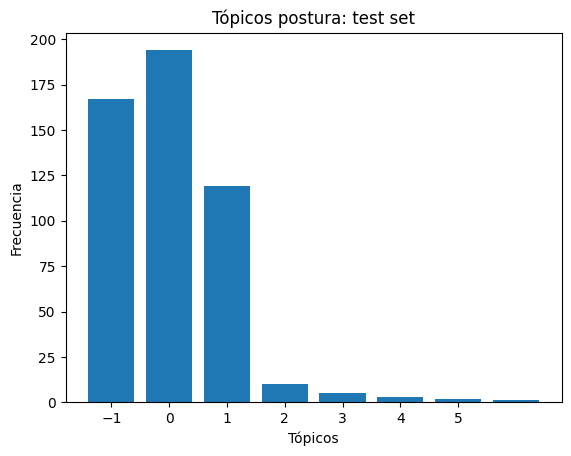

In [19]:
from TM_utils import plot_frecuencies, get_top_k_topics, get_table_top_topics
from utils.exploracion import print_table_md
from utils.preprocesamiento import StemmerTokenizer

tokenizador = StemmerTokenizer(stem=False,rmv_punctuation=True)

output_test = model.transform(df_to_list(df_test,'comment',tokenizador))

plot_frecuencies(output_test[0],label='test set')

In [20]:
top_5_keys, top_5_values = get_top_k_topics(output_test[0],k=5)
print("Tópicos relevantes en test set")

headers, data = get_table_top_topics(model,top_5_keys,top_5_values,max_w=5)
print_table_md(headers, data)

Tópicos relevantes en test set


| Tópico | Probabilidad | Palabra 1 | Palabra 2 | Palabra 3 | Palabra 4 | Palabra 5 |
| --- | --- | --- | --- | --- | --- | --- |
| 0 | 0.3872255489021956 | alicia | proyecto | reputación | si | ser |
| -1 | 0.3333333333333333 | proyecto | criterios | si | entregar | plazos |
| 1 | 0.2375249500998004 | proyecto | plazos | cumplir | si | importante |
| 2 | 0.01996007984031936 | producto | calidad | trabajo | entregar | mejor |
| 3 | 0.00998003992015968 | usuarios | usuario | necesidades | importante | proyecto |


In [21]:
from TM_utils import get_k_random_samples_from_topic

for j, topic in enumerate(top_5_keys):
    df_samples, certainties = get_k_random_samples_from_topic(df_test,output_test,topic)

    print("Ejemplos para tópico ", topic,"\tProporción:","%.1f"%(100*top_5_values[j])+'%')
    for i in range(len(df_samples)):
        print("Sel :",df_samples.iloc[i]['sel'],"\tCertainty: ","%.3f"%(certainties[i]),"\nTexto:", df_samples.iloc[i]['comment'])
    print('\n')

Ejemplos para tópico  0 	Proporción: 38.7%
Sel : 3 	Certainty:  0.815 
Texto: Como grupo acordamos un 3 ya que es necesario priorizáramos entrega más óptima del proyecto pero también hay que hacerlo en el menor plazo posible además de que Alicia también debe priorizar su reputación personal para así luego no sea difícil encontrar trabajo en otro lugar o no la vayan a despedir por dicho atraso.
Sel : 1 	Certainty:  0.999 
Texto: Si Alicia omite las faltas técnicas se puede producir una falla inesperada que causaría consecuencias negativas que se podrían haber evadido por completo al avisar sobre ls fallas y tomar las medidas pertinentes. No notificar podría justamente costarle la reputación a ella y a su empresa si la negligencia de las faltas tecnicas provoca un daño.
Sel : 2 	Certainty:  0.222 
Texto: No cambié mi opinión, sigo considerando que es un 2 ya que es muchísimo más importante ser transparente sin embargo uno tiene que considerar como es el mandante y cómo se va a tomar tus 

### Analizando correlaciones con selección de postura

Por el momento binarizando la postura

In [22]:
df_test.loc[(df_test['sel']==2) | (df_test['sel']==3),'sel'] = 1
df_test.loc[(df_test['sel']==4) | (df_test['sel']==5),'sel'] = 6

In [23]:
output_sel1 = model.transform(df_to_list(df_test[df_test['sel']==1],'comment',tokenizador))

In [24]:
output_sel6 = model.transform(df_to_list(df_test[df_test['sel']==6],'comment',tokenizador))

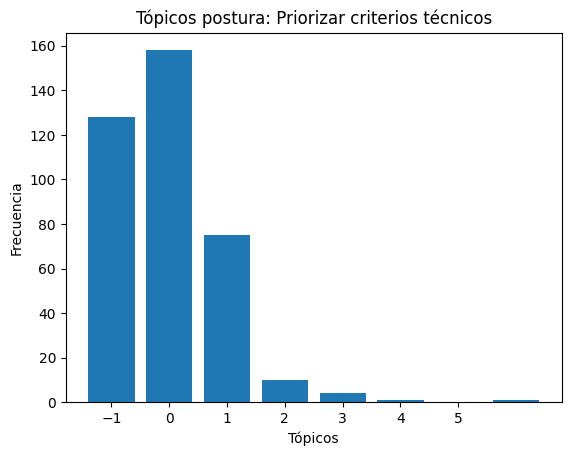

In [25]:
plot_frecuencies(output_sel1[0],label=op_left)

In [26]:
top_5_keys, top_5_values = get_top_k_topics(output_sel1[0])

print("Tópicos relevantes para postura: {}".format(op_left))

headers, data = get_table_top_topics(model,top_5_keys,top_5_values,max_w=5)
print_table_md(headers, data)

Tópicos relevantes para postura: Priorizar criterios técnicos


| Tópico | Probabilidad | Palabra 1 | Palabra 2 | Palabra 3 | Palabra 4 | Palabra 5 |
| --- | --- | --- | --- | --- | --- | --- |
| 0 | 0.41909814323607425 | alicia | proyecto | reputación | si | ser |
| -1 | 0.3395225464190981 | proyecto | criterios | si | entregar | plazos |
| 1 | 0.1989389920424403 | proyecto | plazos | cumplir | si | importante |
| 2 | 0.026525198938992044 | producto | calidad | trabajo | entregar | mejor |
| 3 | 0.010610079575596816 | usuarios | usuario | necesidades | importante | proyecto |


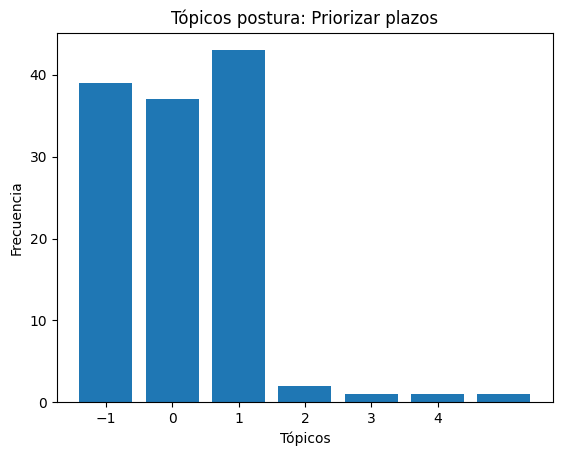

In [27]:
plot_frecuencies(output_sel6[0],label=op_right)

In [28]:
top_5_keys, top_5_values = get_top_k_topics(output_sel6[0])

print("Tópicos relevantes para postura: {}".format(op_right))

headers, data = get_table_top_topics(model,top_5_keys,top_5_values,max_w=5)
print_table_md(headers, data)

Tópicos relevantes para postura: Priorizar plazos


| Tópico | Probabilidad | Palabra 1 | Palabra 2 | Palabra 3 | Palabra 4 | Palabra 5 |
| --- | --- | --- | --- | --- | --- | --- |
| 1 | 0.3467741935483871 | proyecto | plazos | cumplir | si | importante |
| -1 | 0.31451612903225806 | proyecto | criterios | si | entregar | plazos |
| 0 | 0.29838709677419356 | alicia | proyecto | reputación | si | ser |
| 2 | 0.016129032258064516 | producto | calidad | trabajo | entregar | mejor |
| 4 | 0.008064516129032258 | grupo | opinión | argumentos | compañeros | misma |


### Correlaciones

In [29]:
import pandas as pd

df_test = df.iloc[test_indices]
df_test['sel'].value_counts()

arr_test = model.transform(df_to_list(df_test,'comment',tokenizador))[1]
df_topics = pd.DataFrame(arr_test, columns=['Topic{}'.format(i+1) for i in range(num_topics-1)])

df_topics['sel'] = df_test['sel'].values

In [30]:
from scipy.stats import pearsonr

# Only compute pearson prod-moment correlations between feature
# columns and target column
target_col_name = 'sel'
feature_target_corr = {}
for col in df_topics:
    if target_col_name != col:
        feature_target_corr[col + '_' + target_col_name] = \
            pearsonr(df_topics[col], df_topics[target_col_name])[0]
print("Feature-Target Correlations")

for k in feature_target_corr.keys():
    print(k+': '+str(feature_target_corr[k]))

Feature-Target Correlations
Topic1_sel: -0.1916548134054558
Topic2_sel: 0.2245285686737174
Topic3_sel: -0.041303570852329975
Topic4_sel: 0.01988345683104353
Topic5_sel: 0.015041633660771119
Topic6_sel: 0.1171697318422968
Topic7_sel: -0.01166452084513495
Topic8_sel: 0.0521339478302863
Topic9_sel: 0.0698294075984953


Guardando el modelo

In [31]:
model.save("modelos/BT-{}.bertopic".format(caso))

Para cargar:

`my_model = BERTopic.load("modelos/BT-caso.bertopic")`